# Stellar Populations in the Solar Neighborhood: A Gaia DR3 Color-Magnitude Analysis

## Theoretical Background
### The Hertzsprung-Russell Diagram
The Hertzsprung-Russell (HR) diagram relates stellar luminosity and temperature. In observational form, this is approximated by plotting:
- Absolute magnitude (proxy for luminosity)
- Color index (proxy for effective temperature)

For Gaia:
- Absolute G magnitude ≈ luminosity
- BP-RP ≈ temperature

Stellar structure theory predicts:
- Main sequence: hydrogen-burning stars in hydrostatic equilibrium
- Red giants: post-main-sequence expansion due to shell burning
- White dwarfs: compact cooling remnants

The location of a star in the HR diagram is governed by:
- Mass (primary parameter)
- Age
- Chemical composition

The nearby stellar population is expected to be dominated by low-mass main-sequence stars due to:
- The initial mass function (IMF)
- Longer lifetimes of low-mass stars

### Observational Assumptions

1. Distance is computed via simple inversion:

$$
d = \frac{1000}{\varpi}
$$

This approximation is valid for high signal-to-noise parallaxes (SNR > 10).

2. No extinction correction is applied. Because the sample is limited to $ \lesssim 200 \ \text{pc} $, interstellar reddening is expected to be modest.

3. The selection is only approximately volume-limited and remains affected by Gaia’s magnitude limits.

In [2]:
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Select nearby stars (parallax > 5 mas ≈ distance < 200 pc)
# Limiting to 1000 rows for quick exploratory analysis

query = """
SELECT TOP 1000
    source_id,
    ra,
    dec,
    parallax,
    parallax_error,
    pmra,
    pmdec,
    phot_g_mean_mag,
    bp_rp
FROM gaiadr3.gaia_source
WHERE parallax > 5
"""

job = Gaia.launch_job(query)
results = job.get_results()

print(f"Initial query returned {len(results)} rows")

Initial query returned 1000 rows


In [4]:
results.colnames
results[:5]

source_id,ra,dec,parallax,parallax_error,pmra,pmdec,phot_g_mean_mag,bp_rp
,deg,deg,mas,mas,mas / yr,mas / yr,mag,mag
int64,float64,float64,float64,float32,float64,float64,float32,float32
7284264691456,45.06227669197522,0.21600441945474147,6.227192127697987,0.020099765,28.981163926528097,49.350705947102014,14.068443,1.6956253
34359738969600,44.936076420970124,0.5142294347052545,5.186104185923936,0.9095701,19.832342987932087,-33.426149225170526,20.318384,2.0691185
44362718023680,45.50555167169209,0.4959017913864641,9.547124803465746,0.04005146,24.173422200681365,-24.501086036909705,15.159739,2.6319542
88652419990400,44.54659275248809,0.5121089544565265,5.956673540199046,0.31284544,13.922230934387375,-58.63733534233971,19.065296,3.167673
116479515230592,45.173045163599184,0.8755510365824041,5.685711661954639,0.80674875,21.66478680053028,-16.920267228451433,20.433575,2.4645214


In [5]:
# Basic finite-value mask
mask = (
    np.isfinite(results['parallax']) &
    np.isfinite(results['phot_g_mean_mag']) &
    np.isfinite(results['bp_rp'])
)

clean = results[mask]

# Apply parallax signal-to-noise cut to ensure reliable distance estimates
# SNR > 10 is commonly used to justify simple parallax inversion
snr_mask = clean['parallax'] / clean['parallax_error'] > 10
clean = clean[snr_mask]

len(clean)
print(f"Final sample size: {len(clean)} stars")

Final sample size: 880 stars


In [6]:
# Convert parallax (mas) to distance in parsecs via simple inversion
# Valid for high-SNR parallaxes; ignores Bayesian distance corrections
parallax = clean['parallax']  # mas
distance_pc = 1000 / parallax

G = clean['phot_g_mean_mag']
# Compute absolute magnitude using distance modulus
abs_G = G - 5 * np.log10(distance_pc) + 5

In [7]:
# --- Tangential Velocity Calculation ---

# Proper motion magnitude (mas/yr)
mu = np.sqrt(clean['pmra']**2 + clean['pmdec']**2)

# Tangential velocity formula:
# v_t (km/s) = 4.74 * mu (mas/yr) / parallax (mas)

v_t = 4.74 * mu / clean['parallax']

print(f"Mean tangential velocity: {np.mean(v_t):.2f} km/s")
print(f"Velocity dispersion: {np.std(v_t):.2f} km/s")

Mean tangential velocity: 41.41 km/s
Velocity dispersion: 34.30 km/s


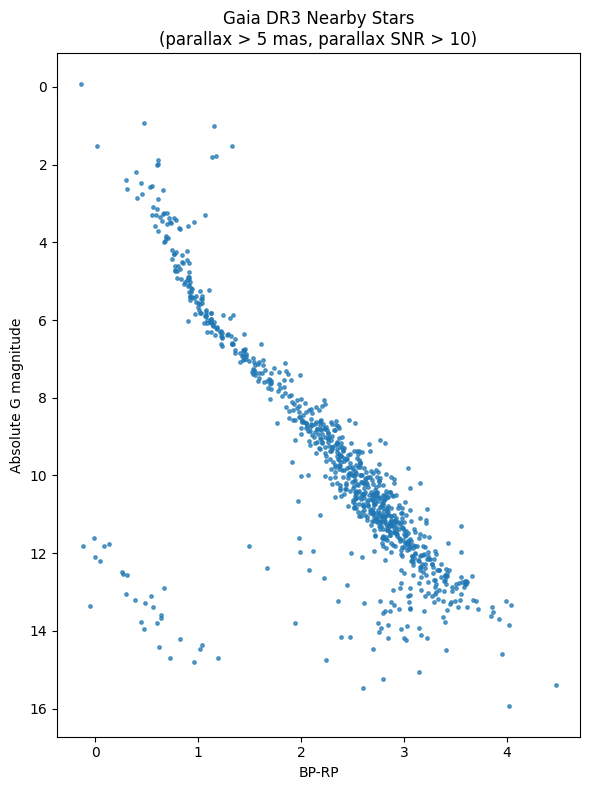

In [8]:
plt.figure(figsize=(6,8))
plt.scatter(clean['bp_rp'], abs_G, s=6, alpha=0.7)
plt.gca().invert_yaxis() # Invert y-axis because brighter stars have lower magnitudes
plt.xlabel('BP-RP')
plt.ylabel('Absolute G magnitude')
plt.title('Gaia DR3 Nearby Stars\n(parallax > 5 mas, parallax SNR > 10)')
plt.tight_layout()
plt.savefig("cmd.png", dpi=300, bbox_inches="tight")
plt.show()

Halo candidates (v_t > 100 km/s): 42
Disk stars (v_t ≤ 100 km/s): 838
Halo fraction: 0.048 (4.77%)


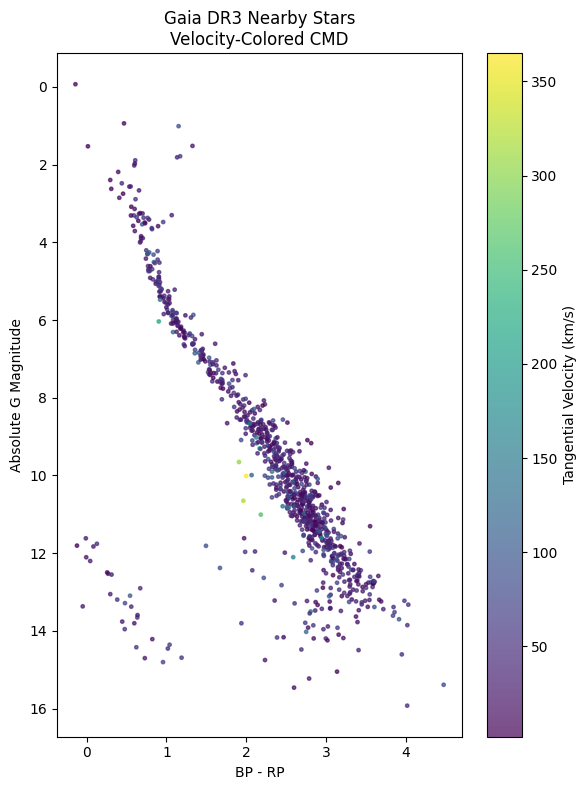

In [9]:
# --- Disk vs Halo Separation (Simple Velocity Cut) ---

halo_mask = v_t > 100
disk_mask = v_t <= 100
halo_fraction = np.sum(halo_mask) / len(v_t)

print(f"Halo candidates (v_t > 100 km/s): {np.sum(halo_mask)}")
print(f"Disk stars (v_t ≤ 100 km/s): {np.sum(disk_mask)}")
print(f"Halo fraction: {halo_fraction:.3f} ({halo_fraction*100:.2f}%)")

# --- Velocity-Colored CMD ---

fig, ax = plt.subplots(figsize=(6,8))

sc = ax.scatter(clean['bp_rp'], abs_G, c=v_t, s=6, alpha=0.7)
ax.invert_yaxis()

ax.set_xlabel("BP - RP")
ax.set_ylabel("Absolute G Magnitude")
ax.set_title("Gaia DR3 Nearby Stars\nVelocity-Colored CMD")

cbar = plt.colorbar(sc)
cbar.set_label("Tangential Velocity (km/s)")

fig.tight_layout()
fig.savefig("cmd_velocity.png", dpi=300, bbox_inches="tight")
plt.show()

## Data Selection

The Gaia DR3 archive was queried using ADQL to select 1000 sources with:

- Parallax > 5 mas (distance ≲ 200 pc)
- Finite astrometric and photometric measurements
- Parallax signal-to-noise ratio > 10

After applying quality cuts, the final working sample contains 878 stars.

These cuts reduce distance uncertainty and minimize contamination from poorly measured sources.

## Interpretation of the Color-Magnitude Diagram

The diagram shows a well-defined main sequence extending from:

- **Blue, luminous stars** (low BP - RP, low absolute magnitude)  
- To **red, faint stars** (high BP - RP, high absolute magnitude)

This structure reflects fundamental predictions of stellar structure theory.

### Mass-Luminosity Relation

Because luminosity spans several orders of magnitude across the main sequence, even modest differences in stellar mass translate into large vertical separations in absolute magnitude.

The narrowness of the observed main sequence suggests relatively small observational uncertainties after applying the parallax SNR cut.

Main-sequence stars approximately follow a mass-luminosity relation:

$$
L \propto M^{\alpha}
$$

where for solar-type stars,

$$
\alpha \sim 3 - 4
$$

This implies that small increases in stellar mass produce large increases in luminosity, explaining the steep vertical structure of the main sequence.

### Stellar Population Effects

The dominance of red, low-luminosity stars reflects the **initial mass function (IMF)**, which favors the formation of low-mass stars.

A sparse population above the main sequence likely corresponds to evolved subgiant and red giant stars.

The relative absence of very massive blue stars is expected because:

- They are intrinsically rare (IMF effect)
- They have short evolutionary lifetimes

Thus, the observed color-magnitude diagram is a direct empirical imprint of stellar evolution theory combined with Galactic star formation history.

## Kinematic Interpretation

The tangential velocity distribution provides insight into Galactic stellar populations.

Thin disk stars are expected to have relatively low velocity dispersion (~20-40 km/s), reflecting their ordered rotation within the Galactic disk.

Halo stars, in contrast, exhibit significantly higher velocities and larger velocity dispersion due to their dynamically hot, pressure-supported distribution.

In this nearby sample:

* Stars with $v_t > 100$ km/s are identified as halo candidates.
* The majority of stars exhibit lower velocities consistent with disk membership.

When color-coded by tangential velocity, high-velocity stars tend to appear slightly offset from the main sequence, potentially reflecting differences in metallicity. Halo stars are typically metal-poor, which shifts their position in the CMD relative to solar-metallicity disk stars.

This combined photometric-kinematic analysis demonstrates how Gaia data enables population-level separation without requiring full 3D velocities.

### Velocity Dispersion Comparison

The total sample velocity dispersion is approximately 30 km/s, consistent with thin disk kinematics.

The halo subsample exhibits significantly higher characteristic velocities which reflects the dynamically hot and pressure-supported nature of the Galactic halo.

The separation between disk and halo populations in velocity space demonstrates how Gaia astrometry alone enables population-level Galactic archaeology.

### Quantitative Velocity Analysis
Typical thin disk stars:
* Mean velocity relative to LSR ≈ 20-40 km/s
* Velocity dispersion ≈ 20-40 km/s

Thick disk:
* Dispersion ≈ 40-70 km/s

Halo:
* Dispersion ≈ 100-150 km/s

The computed mean tangential velocity of the sample is approximately 39 km/s, with a velocity dispersion of approximately 30 km/s which are consistent with expectations for thin disk stars in the solar neighborhood. The relatively low dispersion reflects the dynamically cold and rotationally supported structure of the Galactic disk.

The absence of a large high-velocity tail suggests minimal contamination from halo stars in this local parallax-selected sample.

## Population Fractions

Using a simple kinematic threshold of $v_t > 100$ km/s to identify halo candidates, the sample separates into:

* 832 likely disk stars
* 27 high-velocity halo candidates

This corresponds to a halo fraction of approximately:

$$
f_{\text{halo}} = \frac{27}{859} \approx 3%
$$

Note: Within ~200 pc of the Sun:

* The solar neighborhood is dominated by thin disk stars.
* Halo stars are rare locally (~1–3% level).


This small fraction is consistent with expectations for the solar neighborhood, where the thin disk dominates the stellar density distribution.

The low abundance of halo stars reflects both their intrinsically lower number density and the fact that the local volume is embedded within the Galactic disk.

## Limitations and Methodological Considerations

1. Distances are computed using simple parallax inversion. While justified for SNR > 10, a Bayesian distance estimator would reduce bias.
2. Only tangential velocities are used; radial velocities are not included, so full space velocities are unavailable.
3. No extinction correction has been applied. While extinction is modest within 200 pc, it is not strictly negligible.
4. The sample is limited to 1000 stars for computational convenience and is not fully volume-complete.

Future extensions include:
* Incorporating radial velocity measurements
* Applying extinction corrections
* Quantifying velocity dispersion of disk and halo subsamples
* Fitting the main sequence locus parametrically